# Pós-graduação em Ciência da Computação - UFABC
## Projeto de Mineração de Dados - Professor Thiago Covões
### Alunos: Fernanda Borges e Thiago Rizuti

# Introdução

O objetivo do projeto é interpretar automaticamente captchas de áudio, que neste caso são áudios com quatro caracteres gravados pelos alunos separadamente e concatenados de forma aleatória em arquivos .wav.

Esta base foi crida considerando-se os seguintes caracteres: a,b,c,d,h,m,n,x,6,7. Ela contém 200 observações para o conjunto de treinamento e 147 observações para o conjunto de validação.

Primeiramente desenvolvemos classificadores capazes de distinguir cada caractere separadamente, sendo que cada caractere do captcha representa uma classe. Em seguida consideramos que para cada arquivo .wav recebido a predição é a combinação das predições individuais para cada caractere.

Para realizar este projeto foram usadas as bibliotecas:
- librosa, que é um pacote para análise de áudios e músicas; 
- pandas, que é uma ferramenta para estruturação e análise de dados;
- numpy, que é muito utilizada para computações científicas;
- matplotlib, que é utilizada principalmente para a plotagem de imagens em 2D;
- sklearn, que possui ferramentas para mineração de dados;

In [476]:
import os
import librosa 
import sklearn
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
%matplotlib inline

Também implementamos as seguintes funções, que serão explicadas ao longo do relatório.

In [477]:
%load_ext autoreload
%autoreload 2
%aimport codigo
from codigo import read_audio, extract_features, train_model, evaluation_per_character, evaluation_per_captcha

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Análise Exploratória

O primeiro desafio foi segmentar cada captcha separando o áudio referente a cada caractere. Para isso utilizamos a função load da biblioteca librosa que retorna a série temporal do áudio e a taxa de amostragem dela. Observamos as séries temporais de alguns captchas e identificamos que eles condiziam com o processo de gravação dos áudios, pois havia uma separação visual a cada dois segundos (eixo Time) entre as oscilações mais representativas.

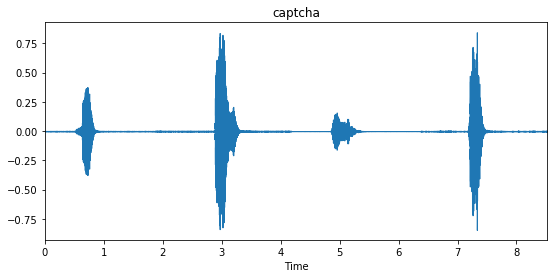

In [478]:
signal, sampling_rate = librosa.load('base_treinamento_I/bnma.wav', None)

plt.figure(figsize=(9, 4))
plt.title('captcha')
librosa.display.waveplot(signal, sr=sampling_rate)

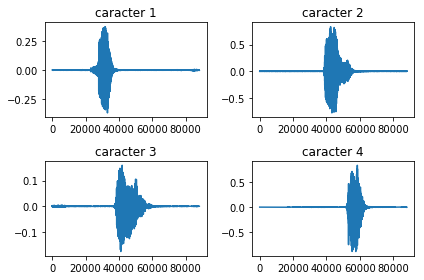

In [479]:
chars = [] 
chars += [signal[sampling_rate*2*i:sampling_rate*2*(i+1)] for i in range(4)]

fig = plt.figure()

plt.subplot(2, 2, 1)
plt.title('caracter 1')
plt.plot(chars[0])

plt.subplot(2, 2, 2)
plt.title('caracter 2')
plt.plot(chars[1])

plt.subplot(2, 2, 3)
plt.title('caracter 3')
plt.plot(chars[2])

plt.subplot(2, 2, 4)
plt.title('caracter 4')
plt.plot(chars[3])
plt.tight_layout()
plt.show()

Decidimos então quebrar a série temporal de cada captcha em 4 intervalo de 2 segundos.

Usamos a função read_audio para ler e dividir em caracteres as bases de treinamento e validação.

In [567]:
train_audios = read_audio('base_treinamento_I') + read_audio('base_treinamento_II') + read_audio('base_validacao_I')
valid_audios = read_audio('base_validacao_II')
print('base de treinamento: ', len(train_audios), ' caracteres')
print('base de validação: ', len(valid_audios), ' caracteres')

base de treinamento:  2020  caracteres
base de validação:  596  caracteres


In [565]:
train_audios = read_audio('base_treinamento_I') 
valid_audios = read_audio('base_validacao_I')
print('base de treinamento: ', len(train_audios), ' caracteres')
print('base de validação: ', len(valid_audios), ' caracteres')

base de treinamento:  800  caracteres
base de validação:  588  caracteres


Para a extração das variáveis de cada caractere utilizamos o Mel Frequency Cepstral Coefficents (MFCCs) que é a ferramenta amplamente utilizada para reconhecimento automático de fala.

Os sons gerados por humanos são filtrados pelo formato do trato vocal, incluindo a língua, os dentes, etc. Este formato determina como o som é emitido. Considerando que seja possível determinar acuradamente este formato, podemos então assumir que temos uma representação acurada do fonema que está sendo reproduzido. 

O formato do trato vocal se manifesta em um envelope do espectro de força em um espaço curto de tempo, e o trabalho dos MFCCs é representar este envelope de maneira precisa.

O processamento do Mel-Frequency Cepstral Coefficients realiza primeiramente o janelamento e aplica a Transformada Discreta de Fourier (DFT). A amplitude da Transformada de Fourier é filtrada por janelas triangulares na escala Mel e então aplica-se o logaritmo. A Transformada Discreta de Cosseno é aplicada e os Coeficientes Mel-Cepstrais são as amplitudes resultantes.

Na função extract_features utilizamos a funcionalidade librosa.feature.mfcc para obter a sequência de MFCCs de cada caractere. Este processo retorna uma matriz com 20 linhas e 173 colunas por caractere. Calculamos então a média da moda, o valor mínimo, o valor máximo, a média, o desvio padrão, a mediana, a amplitude interquartil, a curtose e a assimetria por linha.

In [ ]:
%%time
train_data = extract_features(train_audios)
valid_data = extract_features(valid_audios)

print('base de treinamento: ', train_data.shape)
print('base de validação: ', valid_data.shape)

#  Metodologia

Depois de extrair as variáveis adotamos a mesma abordagem de quando se lida com um problema de classificação tradicional.

Nós utilizamos o GridSearchCV do sklearn para comparar diferentes modelos e configurações de hiperparâmetros. 

Definimos a validação cruzada, de modo que o conjunto de dados de treino disponibilizado pelo professor fosse utilizado para treino e o conjunto de dados de validação fosse utilizado para calcular a métrica de avaliação (acurácia). 
Executamos o grid search uma vez para cada um dos modelos com cada uma das diferentes combinações de hiperparâmetros , calculando assim a acurácia na base de validação. 
Desta maneira foi possível escolher o melhor modelo com a melhor combinação de hiperparâmetros selecionando o maior best_score.

Os modelos testados foram: 
- k-nearest neighbors (hiperparâmetros: número de vizinhos, votação uniforme ou ponderada pela distância, distâncias de manhattan e euclidiana)
- Regressão Logística (peso da regularização, regularizão l1 e l2)
- Random Forest (profundidade máxima e número de árvores.

Antes de treinar os modelos, usamos também o StandardScaler do sklearn para normalizar os dados com z-score.

A metodologia descrita foi toda implementada na função train_model. 
A função recebe os dados de treinamento e validação, a lista de modelos, lista de hiperparâmetros, o normalizador e a métrica a ser utilizada. Retornando o normalizador ajustado, o melhor modelo treinado e uma tabela de resultados do gridsearch.

In [573]:
%%time
model = train_model(train_data)

print(model)

/Users/thiago/Library/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/thiago/Library/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/thiago/Library/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/thiago/Library/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

OneVsOneClassifier(estimator=VotingClassifier(estimators=[('knn', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', SelectKBest(k=10, score_func=<function mutual_info_classif at 0x10fa39d08>)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size...e=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None),
          n_jobs=1)
CPU times: user 12min 8s, sys: 3.56 s, total: 12min 11s
Wall time: 12min 20s


In [576]:
metrics, conf = evaluation_per_character(model,valid_data)
print(metrics)
print(conf)

             precision    recall  f1-score   support

          6       0.18      0.13      0.15        70
          7       0.26      0.14      0.19        63
          a       0.26      0.34      0.30        64
          b       0.17      0.15      0.16        53
          c       0.27      0.24      0.25        66
          d       0.00      0.00      0.00        55
          h       0.32      0.36      0.34        56
          m       0.25      0.11      0.15        57
          n       0.20      0.38      0.26        45
          x       0.19      0.40      0.26        67

avg / total       0.21      0.22      0.21       596

   d   c   n   6  7   x  m   a  b   h
d  0   3  12   3  1  11  4   8  5   8
c  1  16   0  12  4  17  1   5  9   1
n  0   0  17   1  3   5  2   7  5   5
6  3   7   6   9  1  22  3   9  5   5
7  0   9   3   3  9  30  0   4  3   2
x  0   5   3   9  5  27  1   4  4   9
m  1   0  18   4  1   8  6   9  6   4
a  1   8   7   5  2  10  2  22  2   5
b  0  10   6   3  6

In [577]:
evaluation_per_captcha(model,valid_data)

0.0

In [ ]:
X = train_data.drop(['captcha_label','char_label'],axis=1)
y = train_data['char_label']
clf.fit(X,y)

In [ ]:
metrics, conf = evaluation_per_character(clf,valid_data)
print(metrics)
print(conf)

In [ ]:
evaluation_per_captcha(clf,valid_data)

#  Resultados

Implementamos a função evaluate_by_character para avaliar com mais detalhes o melhor modelo escolhido. A função calcula a matriz de confusão, precision, recall e f1 para cada classe. 

Analisando as métricas e a matriz de confusão, podemos observar que alguns caracteres são classificados com pouco erro, como 'a','x' e 'h'. Entretanto o modelo se confunde mais entre 'm' e 'n', entre 'b' e 'd', entre 'c' e '7', entre 'c' e '6'.

In [ ]:
metrics, conf = evaluation_per_character(transformer,best_model,valid_data)
taxa_caractere = evaluation_per_captcha(transformer,best_model,valid_data)

print('Métricas por caractere')
print(metrics)
print('Matriz de confusão')
print(conf)

Por fim criamos a função evaluation_per_captcha que retorna a quantidade de captchas nos quais nosso melhor modelo foi capaz de acertar os 4 caracteres, dividida pela quantidade total de captchas de validação. Sendo que nosso resultado final foi acertar aproximadamente 40% dos captchas de validação.

In [ ]:
evaluation_per_captcha(transformer,best_model,valid_data)

# Comentários Finais

Na avaliação do modelo, notamos que este sofre com overfitting e que alguns caracteres são confundidos com maior frequência.
Para melhorar o desempenho do modelo e aumentar nossa taxa de acerto por caractere, definimos como próximos passos:
- Extrair mais variáveis através do mfcc;
- Explorar outras bibliotecas de extração de variáveis, por exemplo a python_speech_features;
- Fazer seleção de features
- Usar kfold no gridsearch para minimizar o overfitting;
- Testar ensembles e classificadores específicos para os caracteres mais similares;

# Resultados no conjunto de testes
Incluímos esta sessão para que o professor possa testar nossa solução em um novo conjunto de dados.

Basta definir o caminho para o diretório contendo os aúdios e executar a célula.

In [ ]:
path = ' '

final_train_data = pd.concat([train_data,valid_data],ignore_index=True)
X = final_train_data.drop(['captcha_label','char_label'],axis=1)
y = final_train_data['char_label']
X = pd.DataFrame(transformer.transform(X),columns=X.columns)
model.fit(X,y)

test_audios = read_audio(caminho)
test_data = extract_features(test_audios)
metrics, conf = evaluation_per_character(transformer,best_model,test_data)
taxa_caractere = evaluation_per_captcha(transformer,best_model,valid_data)

print('Métricas por caractere')
print(metrics)
print('Matriz de confusão')
display(conf)
print('\n\nTaxa de acerto por captchas')
print(taxa_caractere)

# Referências

http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

http://abricom.org.br/wp-content/uploads/2016/03/bricsccicbic2013_submission_55.pdf

https://librosa.github.io/librosa/index.html

http://scikit-learn.org/stable/modules/classes.html
